<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/DS_Unit_2_Sprint_Challenge_3_Classification_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.4MB/s 


 _Lambda School Data Science Unit 2_
 
 # Classification & Validation Sprint Challenge

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

#### For this Sprint Challenge, you'll predict whether a person's income exceeds $50k/yr, based on census data.

You can read more about the Adult Census Income dataset at the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/adult

#### Run this cell to load the data:

In [0]:
import pandas as pd

columns = ['age', 
           'workclass', 
           'fnlwgt', 
           'education', 
           'education-num', 
           'marital-status', 
           'occupation', 
           'relationship', 
           'race', 
           'sex', 
           'capital-gain', 
           'capital-loss', 
           'hours-per-week', 
           'native-country', 
           'income']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                 header=None, names=columns)

df['income'] = df['income'].str.strip()

## Part 1 — Begin with baselines

Split the data into an **X matrix** (all the features) and **y vector** (the target).

(You _don't_ need to split the data into train and test sets here. You'll be asked to do that at the _end_ of Part 1.)

In [3]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [0]:
features=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
target='income'

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You can answer this question either with a scikit-learn function or with a pandas function.)

In [16]:
#it will either be the percentage of the majority class....
from sklearn.metrics import accuracy_score
df['income'].value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: income, dtype: float64

In [0]:
import numpy as np
df['income_binary']=np.where(df['income']=='<=50K',0,1)

In [0]:
df['majority_class_baseline']=0

In [22]:
#or you use sklearn function to calculate same number
accuracy_score(df['income_binary'],df['majority_class_baseline'])

0.7591904425539756

What **ROC AUC score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of ROC AUC.)

In [0]:
# this will be 0.5 as roc curve will be a straight line going from (0,0) to (1,1) so area under the curve is 0.5

In [24]:
#using sklearn
from sklearn.metrics import roc_auc_score
roc_auc_score(df['income_binary'], df['majority_class_baseline'])

0.5

In this Sprint Challenge, you will use **"Cross-Validation with Independent Test Set"** for your model validaton method.

First, **split the data into `X_train, X_test, y_train, y_test`**. You can include 80% of the data in the train set, and hold out 20% for the test set.

In [0]:
target='income_binary'
X=df[features].copy()
y=df[target].copy()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Part 2 — Modeling with Logistic Regression!

- You may do exploratory data analysis and visualization, but it is not required.
- You may **use all the features, or select any features** of your choice, as long as you select at least one numeric feature and one categorical feature.
- **Scale your numeric features**, using any scikit-learn [Scaler](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) of your choice.
- **Encode your categorical features**. You may use any encoding (One-Hot, Ordinal, etc) and any library (category_encoders, scikit-learn, pandas, etc) of your choice.
- You may choose to use a pipeline, but it is not required.
- Use a **Logistic Regression** model.
- Use scikit-learn's [**cross_val_score**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function. For [scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules), use **accuracy**.
- **Print your model's cross-validation accuracy score.**

In [34]:
#i've checked for missing data so no need to use imputer
X_train.isna().sum()[:4]

age          0
workclass    0
fnlwgt       0
education    0
dtype: int64

In [39]:
#there doesn't seem to be overly many categories in each categorical column so will just set them to categoricals
#X_train['occupation'].value_counts()#X_train['marital-status'].value_counts()#X_train['education'].value_counts()#X_train['workclass'].value_counts()



 Prof-specialty       3312
 Craft-repair         3278
 Exec-managerial      3228
 Adm-clerical         3044
 Sales                2921
 Other-service        2628
 Machine-op-inspct    1624
 ?                    1454
 Transport-moving     1280
 Handlers-cleaners    1097
 Farming-fishing       801
 Tech-support          739
 Protective-serv       513
 Priv-house-serv       123
 Armed-Forces            6
Name: occupation, dtype: int64

In [0]:
#getting rid of warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [48]:
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

preprocessor=make_pipeline(ce.OrdinalEncoder(),StandardScaler())

processed_Xtrain= preprocessor.fit_transform(X_train)
#just checking it was looking ok!  pd.DataFrame(processed_Xtrain).head()
LogReg=LogisticRegression(solver='lbfgs', max_iter=1000)
LogReg.fit(processed_Xtrain,y_train)
scores_array=cross_val_score(LogReg, processed_Xtrain, y_train, scoring='accuracy', cv=5)
scores_array

array([0.82207294, 0.82975048, 0.82015355, 0.8187752 , 0.83086965])

In [49]:
#printing mean score for final cv score
scores_array.mean()

0.8243243625660446

## Part 3 — Modeling with Tree Ensembles!

Part 3 is the same as Part 2, except this time, use a **Random Forest** or **Gradient Boosting** classifier. You may use scikit-learn, xgboost, or any other library. Then, print your model's cross-validation accuracy score.

In [50]:
from sklearn.ensemble import RandomForestClassifier

rand_for=RandomForestClassifier(max_depth=3, n_estimators=100,n_jobs=-1, random_state=42)

RF_scores = cross_val_score(rand_for, processed_Xtrain, y_train, scoring='accuracy', cv=5)
RF_scores

array([0.82341651, 0.82975048, 0.82495202, 0.82472644, 0.83163755])

In [51]:
#final accuracy score for random forest is slightly higher
RF_scores.mean()

0.8268965974658506

#Feature engineering

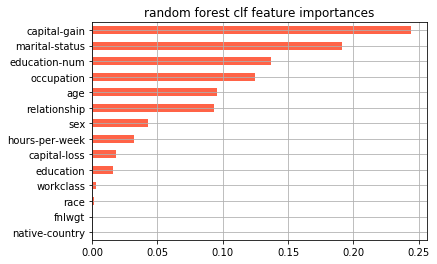

In [69]:

#now let's look at feature importance when we used teh random forest classifier
import matplotlib.pyplot as plt
rand_for.fit(processed_Xtrain,y_train)
importances = pd.Series(rand_for.feature_importances_, X_train.columns)
title='random forest clf feature importances'
importances.sort_values().plot.barh(color='#FF6347', title=title)
plt.grid()
plt.show()

In [0]:
#we can see capital gain is by far teh most important followed by marital status
#native country, fnlwgt, race and worlclass have 0 or almost 0 importance so we can eliminate those

In [0]:
#first of all columns education and education-num are one and the same - 
#jsut a number code for each entry so we can eliminate 'education column'
new_features=['age', 'workclass', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week']
target='income_binary'

#model selection


In [0]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

In [89]:
models = [LogisticRegression(solver='lbfgs', max_iter=1000), 
          DecisionTreeClassifier(max_depth=3),  
          RandomForestClassifier(max_depth=3, n_estimators=100, n_jobs=-1, random_state=42), 
          XGBClassifier(max_depth=3, n_estimators=100, n_jobs=-1, random_state=42)]

X_cut=X.copy()[new_features]
X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.2, random_state=42)
processors=[make_pipeline(ce.OrdinalEncoder(),StandardScaler()),make_pipeline(ce.OrdinalEncoder(),MinMaxScaler())]

for model in models:
  for processor in processors:
            processed_Xtrain= processor.fit_transform(X_train)
            print('{} '.format(model)[:15],' and ',processor, '\n')
            threshold = 0.5
            score = cross_val_score(model, processed_Xtrain, y_train, scoring='accuracy', cv=5).mean()
            print('Cross-Validation Accuracy:', score, '\n', '\n')
            y_pred_proba=cross_val_predict(model, processed_Xtrain, y_train, cv=5, n_jobs=-1, 
                                 method='predict_proba')[:,1]
            y_pred=y_pred_proba>threshold
            cm=pd.DataFrame(confusion_matrix(y_train, y_pred), 
            columns=['Predicted Negative', 'Predicted Positive'], 
            index=['Actual Negative', 'Actual Positive'])
            print(cm)

LogisticRegress  and  Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
        mapping=[{'col': 'workclass', 'mapping':  Local-gov           1
 Private          ..._df=True, verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))]) 

Cross-Validation Accuracy: 0.8244011379979064 
 

                 Predicted Negative  Predicted Positive
Actual Negative               18675                1103
Actual Positive                3471                2799
LogisticRegress  and  Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
        mapping=[{'col': 'workclass', 'mapping':  Local-gov        

In [91]:
#so it looks like XGB classifier was way out in front on >86% accuracy and minmax/standard made no difference
#let's use grid search to determine the best parameters

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

process=make_pipeline(ce.OrdinalEncoder(),StandardScaler())
processed_Xtrain= process.fit_transform(X_train)

depths=[2,3] 
n_estimator=[75,100,150]
booster=['gbtree', 'gblinear', 'dart']
#thresholds=[0.5,0.6,0.7]
param_grid = [{'max_depth': [2,3] , 'n_estimators': [75,100,150],'booster': ['gbtree', 'gblinear', 'dart']}]
scores = ['accuracy']
 
for score in scores:
  xgb=GridSearchCV(XGBClassifier(n_jobs=-1,random_state=42),param_grid,scoring=score)
  xgb.fit(processed_Xtrain,y_train)
  print("Best parameters set found on grid:")
  print()
  print(xgb.best_params_)

Best parameters set found on grid:

{'booster': 'gbtree', 'max_depth': 3, 'n_estimators': 150}


In [93]:
final_model=XGBClassifier(max_depth=3,booster='gbtree',n_estimators=150,n_jobs=-1,random_state=42)
#so best params were gbtree, 150 estimators and max_depth 3
#let's run that for a confusion matrix
threshold = 0.5
score = cross_val_score(final_model, processed_Xtrain, y_train, scoring='accuracy', cv=5).mean()
print('Cross-Validation Accuracy:', score, '\n', '\n')
y_pred_proba=cross_val_predict(model, processed_Xtrain, y_train, cv=5, n_jobs=-1, 
                                 method='predict_proba')[:,1]
y_pred=y_pred_proba>threshold
cm=pd.DataFrame(confusion_matrix(y_train, y_pred), 
columns=['Predicted Negative', 'Predicted Positive'], 
            index=['Actual Negative', 'Actual Positive'])
print(cm)

Cross-Validation Accuracy: 0.8664007186734608 
 

                 Predicted Negative  Predicted Positive
Actual Negative               18814                 964
Actual Positive                2611                3659


final score was slightly above after fine tuning parameters
Cross-Validation Accuracy: 0.8664007186734608 


# Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

Calculate accuracy

In [0]:
#first i split the numbers into tru/false positives/negatives
true_positives=36  #predicted positive and WAS positive
true_negatives=85  #predicted negative and WAS negative
false_positives=58 #predicted positive BUT was negative
false_negatives=8 #predicted negative BUT was positive

total=36+85+58+8

In [55]:
accuracy=(true_positives+true_negatives)/total
accuracy

0.6470588235294118

Calculate precision

In [58]:
precision=true_positives/(true_positives+false_positives)
precision

0.3829787234042553

Calculate recall

In [61]:
recall=true_positives/(true_positives+false_negatives)
recall

0.8181818181818182

In [96]:
#F1 = 2 * (precision * recall) / (precision + recall)
2*(precision*recall)/(precision+recall)

0.5217391304347826

In [97]:
#falsepositives rate is false positives/total number of negatives
58/(85+58)

0.40559440559440557

# BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Experiment with feature selection, preprocessing, categorical encoding, and hyperparameter optimization, to try improving your cross-validation score.

### Part 3
Which model had the best cross-validation score? Refit this model on the train set and do a final evaluation on the held out test set — what is the test score? 

### Part 4
Calculate F1 score and False Positive Rate. 